In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from textwrap import wrap
import sarchl


rc('text', usetex=False)
sns.set_context('paper', font_scale=2.0)
sns.set_style('whitegrid')

In [2]:
benchmarks=[
    "aes",
    "atax",
    "bicg",
    "bitonicsort",
    "conv2d",
    "fastwalshtrasnform",
    "fir",
    "fft",
    "floydwarshall",
    "im2col",
    "kmeans",
    "matrixmultiplication",
    "matrixtranspose",
    "nbody",
    "nw",
    "pagerank",
    "relu",
    "simpleconvolution",
    "spmv",
    "stencil2d",
]

benchmark_acronyms = {
    "aes": "AES",
    "atax": "ATAX",
    "bicg": "BICG",
    "bitonicsort": "BS",
    "conv2d": "CONV",
    "fastwalshtrasnform": "FWT",
    "fir": "FIR",
    "fft": "FFT",
    "floydwarshall": "FW",
    "im2col": "I2C",
    "kmeans": "KM",
    "matrixmultiplication": "MM",
    "matrixtranspose": "MT",
    "nbody": "NB",
    "nw": "NW",
    "pagerank": "PR",
    "relu": "RELU",
    "simpleconvolution": "SC",
    "spmv": "SPMV",
    "stencil2d": "ST",
}



In [3]:
options=["-switch-latency"]
option_values= {
    "-switch-latency": [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
}

## Load Data

In [4]:
def metric_filename(model_name, benchmark, option_values):
    file_name = model_name + '_' + benchmark + '_'

    for option in options:
        option_value = option_values[option]
        file_name += option + '=' + str(option_value) + '_'
        
    file_name += 'metrics.csv'

    return file_name


def load_data(model_name, benchmark, option_values, data_frame):
    file_name = metric_filename(model_name, benchmark, option_values)

    try:
        df = pd.read_csv(file_name, skipinitialspace=True, index_col=0)
    except FileNotFoundError:
        print("File not found: " + file_name)
        return data_frame
    
    df['benchmark'] = benchmark_acronyms[benchmark]
    for option in options:
        option_value = option_values[option]
        df[option] = option_value

    data_frame = data_frame.append(df)

    return data_frame

In [5]:
columns = ["benchmark"] + options + ["where", "what", "value"]
raw = pd.DataFrame(columns=columns)

option_permutation_count = 1
for option in options:
    option_permutation_count *= len(option_values[option])

for b in benchmarks:
    for option_id in range(option_permutation_count):
        ov = {}

        for option in options:
            ov[option] = \
                option_values[option][option_id % len(option_values[option])]
            option_id //= len(option_values[option])

        # print(ov)

        raw = load_data(b, ov, raw)

print(raw.head(), raw.tail())

File not found: model1_fastwalshtrasnform_-switch-latency=1_metrics.csv
File not found: model1_fastwalshtrasnform_-switch-latency=2_metrics.csv
File not found: model1_fastwalshtrasnform_-switch-latency=5_metrics.csv
File not found: model1_fastwalshtrasnform_-switch-latency=10_metrics.csv
File not found: model1_fastwalshtrasnform_-switch-latency=20_metrics.csv
File not found: model1_fastwalshtrasnform_-switch-latency=50_metrics.csv
File not found: model1_fastwalshtrasnform_-switch-latency=100_metrics.csv
File not found: model1_fastwalshtrasnform_-switch-latency=200_metrics.csv
File not found: model1_fastwalshtrasnform_-switch-latency=500_metrics.csv
File not found: model1_fastwalshtrasnform_-switch-latency=1000_metrics.csv
File not found: model1_nbody_-switch-latency=500_metrics.csv
File not found: model1_spmv_-switch-latency=200_metrics.csv
  benchmark -switch-latency                     where         what     value
0       AES               1                    driver  kernel_time  0.

In [6]:
print(raw.tail())

      benchmark -switch-latency           where               what     value
14925        ST            1000  GPU_4_4.DRAM_7  write_trans_count      15.0
14926        ST            1000  GPU_4_4.DRAM_7   read_avg_latency       0.0
14927        ST            1000  GPU_4_4.DRAM_7  write_avg_latency       0.0
14928        ST            1000  GPU_4_4.DRAM_7          read_size  292480.0
14929        ST            1000  GPU_4_4.DRAM_7         write_size     960.0


## Kernel Time Analysis

In [7]:
kernel_time_data = raw[(raw['where']=='driver') & (raw['what']=='kernel_time')]
kernel_time_data

,benchmark,-switch-latency,where,what,value
0,AES,1,driver,kernel_time,0.001477
0,AES,2,driver,kernel_time,0.001453
0,AES,5,driver,kernel_time,0.001485
0,AES,10,driver,kernel_time,0.001466
0,AES,20,driver,kernel_time,0.001373
...,...,...,...,...,...
0,ST,50,driver,kernel_time,0.000000
0,ST,100,driver,kernel_time,0.000000
0,ST,200,driver,kernel_time,0.000000
0,ST,500,driver,kernel_time,0.000000


In [8]:
kernel_time_data_pivot = kernel_time_data.pivot(
    index='benchmark', 
    columns=['-switch-latency'], 
    values='value',
)
kernel_time_data_pivot = kernel_time_data_pivot.reset_index()
kernel_time_data_pivot.columns = ['benchmark', '1', '2', '5', '10', '20', '50', '100', '200', '500', '1000']
kernel_time_data_pivot

,benchmark,1,2,5,10,20,50,100,200,500,1000
0,AES,0.001477,0.001453,0.001485,0.001466,0.001373,0.001264,0.001196,0.001102,0.001139,0.001819
1,ATAX,0.089427,0.089442,0.089506,0.089644,0.094433,0.157555,0.267928,0.491993,1.164912,2.286556
2,BICG,0.089368,0.089380,0.089434,0.089567,0.094363,0.156814,0.266630,0.487655,1.152399,2.262270
3,BS,0.017912,0.017542,0.017211,0.017257,0.016881,0.016424,0.015112,0.014311,0.016238,0.029205
4,CONV,0.017742,0.017244,0.017025,0.016666,0.016121,0.014735,0.013750,0.013017,0.012934,0.017112
5,FFT,0.007639,0.007560,0.007352,0.007140,0.006898,0.006463,0.005967,0.005919,0.006848,0.010231
6,FIR,0.000019,0.000020,0.000020,0.000019,0.000019,0.000022,0.000027,0.000033,0.000060,0.000109
7,FW,0.181342,0.178557,0.174066,0.166580,0.159756,0.154797,0.159398,0.182862,0.378936,0.743670
8,I2C,0.005039,0.004965,0.004950,0.004804,0.004674,0.004276,0.003760,0.003469,0.002525,0.003481
9,KM,0.065181,0.063935,0.061492,0.058121,0.055299,0.050465,0.048314,0.045451,0.047711,0.070162


In [9]:
# Normalize data
kernel_time_data_normalize = kernel_time_data_pivot.copy()
kernel_time_data_normalize['2'] = \
    kernel_time_data_normalize['1'] / kernel_time_data_normalize['2']
kernel_time_data_normalize['5'] = \
    kernel_time_data_normalize['1'] / kernel_time_data_normalize['5']
kernel_time_data_normalize['10'] = \
    kernel_time_data_normalize['1'] / kernel_time_data_normalize['10']
kernel_time_data_normalize['20'] = \
    kernel_time_data_normalize['1'] / kernel_time_data_normalize['20']
kernel_time_data_normalize['50'] = \
    kernel_time_data_normalize['1'] / kernel_time_data_normalize['50']
kernel_time_data_normalize['100'] = \
    kernel_time_data_normalize['1'] / kernel_time_data_normalize['100']
kernel_time_data_normalize['200'] = \
    kernel_time_data_normalize['1'] / kernel_time_data_normalize['200']
kernel_time_data_normalize['500'] = \
    kernel_time_data_normalize['1'] / kernel_time_data_normalize['500']
kernel_time_data_normalize['1000'] = \
    kernel_time_data_normalize['1'] / kernel_time_data_normalize['1000']
kernel_time_data_normalize['1'] = 1
kernel_time_data_normalize

,benchmark,1,2,5,10,20,50,100,200,500,1000
0,AES,1,1.016399,0.994386,1.007271,1.075869,1.168836,1.234899,1.340430,1.296594,0.812060
1,ATAX,1,0.999822,0.999116,0.997577,0.946987,0.567588,0.333771,0.181764,0.076767,0.039110
2,BICG,1,0.999865,0.999270,0.997786,0.947072,0.569901,0.335177,0.183262,0.077550,0.039504
3,BS,1,1.021127,1.040776,1.037998,1.061128,1.090621,1.185284,1.251659,1.103143,0.613327
4,CONV,1,1.028834,1.042076,1.064573,1.100526,1.204087,1.290279,1.362950,1.371761,1.036805
5,FFT,1,1.010488,1.039092,1.069823,1.107430,1.182012,1.280245,1.290498,1.115574,0.746658
6,FIR,1,0.991164,0.986528,1.031411,1.012945,0.882693,0.715139,0.584131,0.324445,0.177263
7,FW,1,1.015599,1.041804,1.088622,1.135119,1.171482,1.137667,0.991690,0.478557,0.243848
8,I2C,1,1.014749,1.017835,1.048862,1.077899,1.178218,1.340087,1.452645,1.995629,1.447609
9,KM,1,1.019495,1.059992,1.121471,1.178708,1.291624,1.349131,1.434087,1.366184,0.929015


In [10]:
kernel_time_data_melt = kernel_time_data_normalize.melt(
    id_vars=['benchmark'],
    value_vars=['2', '5', '10', '20', '50', '100', '200', '500', '1000'],
    var_name='-switch-latency',
    value_name='value',
)
kernel_time_data_melt

,benchmark,-switch-latency,value
0,AES,2,1.016399
1,ATAX,2,0.999822
2,BICG,2,0.999865
3,BS,2,1.021127
4,CONV,2,1.028834
...,...,...,...
166,PR,1000,0.911376
167,RELU,1000,1.184502
168,SC,1000,0.944089
169,SPMV,1000,0.816988


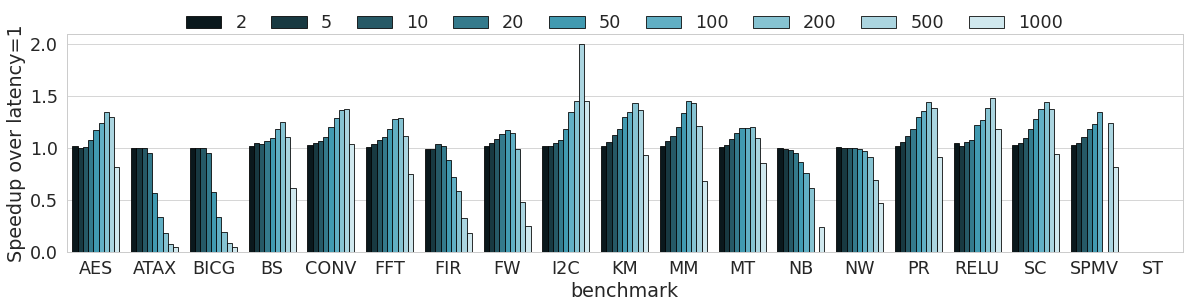

In [11]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(data = kernel_time_data_melt, 
    x='benchmark', y='value', hue='-switch-latency', 
    palette=sarchl.sequential_palette(9),
    ec='k',
    ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, 
          frameon=False,
          fancybox=None, 
          columnspacing=1.4,
          facecolor=None, edgecolor=None, 
          bbox_to_anchor=(0.5, 1.05), loc=10, ncol=9)

ax.set_ylabel("Speedup over latency=1")

plt.savefig('exec_time.pdf', bbox_inches='tight')
plt.show()
plt.close()

## L1 Cache Analysis

In [12]:
l1_data_avg_latency_data = raw[(raw['where'].str.contains('L1VCache')) & (raw['what']=='req_average_latency')]
l1_data_avg_latency_data

,benchmark,-switch-latency,where,what,value
810,AES,1,GPU_0_0.SA_00.L1VCache_00,req_average_latency,2.282800e-07
811,AES,1,GPU_0_0.SA_00.L1VCache_01,req_average_latency,2.269370e-07
812,AES,1,GPU_0_0.SA_00.L1VCache_02,req_average_latency,1.958500e-07
813,AES,1,GPU_0_0.SA_00.L1VCache_03,req_average_latency,2.869880e-07
814,AES,1,GPU_0_0.SA_01.L1VCache_00,req_average_latency,2.355110e-07
...,...,...,...,...,...
2125,ST,1000,GPU_4_4.SA_06.L1VCache_03,req_average_latency,7.154611e-06
2126,ST,1000,GPU_4_4.SA_07.L1VCache_00,req_average_latency,6.802037e-06
2127,ST,1000,GPU_4_4.SA_07.L1VCache_01,req_average_latency,7.083271e-06
2128,ST,1000,GPU_4_4.SA_07.L1VCache_02,req_average_latency,6.804853e-06


In [13]:
l1_benchmark_avg_latency_data = l1_data_avg_latency_data \
    .groupby(['benchmark', '-switch-latency']).mean()
l1_benchmark_avg_latency_data = l1_benchmark_avg_latency_data.reset_index()
l1_benchmark_avg_latency_data

,benchmark,-switch-latency,value
0,AES,1,1.974551e-07
1,AES,2,1.934476e-07
2,AES,5,2.020659e-07
3,AES,10,1.983670e-07
4,AES,20,1.927280e-07
...,...,...,...
183,ST,50,1.572182e-06
184,ST,100,1.627216e-06
185,ST,200,1.782692e-06
186,ST,500,3.496741e-06


In [14]:
l1_latency_pivot = l1_benchmark_avg_latency_data.pivot(
    index='benchmark',
    columns='-switch-latency',
    values='value',
).reset_index()
l1_latency_pivot.columns = ['benchmark', '1', '2', '5', '10', '20', '50', '100', '200', '500', '1000']
l1_latency_pivot

,benchmark,1,2,5,10,20,50,100,200,500,1000
0,AES,1.974551e-07,1.934476e-07,2.020659e-07,1.983670e-07,1.927280e-07,1.903043e-07,1.831137e-07,1.927336e-07,2.069602e-07,2.973931e-07
1,ATAX,1.038760e-06,1.040449e-06,1.046484e-06,1.050921e-06,1.106248e-06,1.860543e-06,3.206999e-06,5.890007e-06,1.394376e-05,2.735437e-05
2,BICG,1.038795e-06,1.040456e-06,1.045951e-06,1.050470e-06,1.105665e-06,1.851581e-06,3.194694e-06,5.852627e-06,1.382344e-05,2.710721e-05
3,BS,4.708162e-06,4.618670e-06,4.395773e-06,4.304266e-06,4.051743e-06,3.973116e-06,3.113659e-06,2.668862e-06,2.417457e-06,3.778573e-06
4,CONV,4.225087e-06,4.265238e-06,4.164518e-06,4.073119e-06,3.955137e-06,3.741512e-06,3.754458e-06,3.719348e-06,3.875599e-06,4.779989e-06
5,FFT,6.637192e-06,7.125288e-06,6.655712e-06,6.335523e-06,5.690927e-06,6.068655e-06,5.391138e-06,5.488622e-06,5.449945e-06,6.740931e-06
6,FIR,3.022111e-07,2.993056e-07,3.066346e-07,2.914139e-07,2.737791e-07,2.287232e-07,2.516169e-07,2.822049e-07,4.405141e-07,7.611131e-07
7,FW,4.751706e-06,4.678437e-06,4.444946e-06,4.246929e-06,4.075638e-06,3.828773e-06,3.798882e-06,4.010995e-06,7.117861e-06,1.390140e-05
8,I2C,8.455944e-06,8.120942e-06,8.056455e-06,8.574615e-06,7.596082e-06,6.661952e-06,6.030420e-06,5.217163e-06,4.583817e-06,5.738836e-06
9,KM,3.542755e-06,3.508824e-06,3.477684e-06,3.455150e-06,3.456498e-06,3.386081e-06,3.352805e-06,3.555908e-06,4.681197e-06,6.682431e-06


In [15]:
l1_latency_normalize = l1_latency_pivot.copy()
l1_latency_normalize['2'] = \
    l1_latency_normalize['2'] / l1_latency_normalize['1']
l1_latency_normalize['5'] = \
    l1_latency_normalize['5'] / l1_latency_normalize['1']
l1_latency_normalize['10'] = \
    l1_latency_normalize['10'] / l1_latency_normalize['1']
l1_latency_normalize['20'] = \
    l1_latency_normalize['20'] / l1_latency_normalize['1']
l1_latency_normalize['50'] = \
    l1_latency_normalize['50'] / l1_latency_normalize['1']
l1_latency_normalize['100'] = \
    l1_latency_normalize['100'] / l1_latency_normalize['1']
l1_latency_normalize['200'] = \
    l1_latency_normalize['200'] / l1_latency_normalize['1']
l1_latency_normalize['500'] = \
    l1_latency_normalize['500'] / l1_latency_normalize['1']
l1_latency_normalize['1000'] = \
    l1_latency_normalize['1000'] / l1_latency_normalize['1']
l1_latency_normalize['1'] = 1
l1_latency_normalize


,benchmark,1,2,5,10,20,50,100,200,500,1000
0,AES,1,0.979704,1.023351,1.004618,0.976060,0.963785,0.927369,0.976088,1.048138,1.506131
1,ATAX,1,1.001625,1.007436,1.011707,1.064970,1.791119,3.087333,5.670229,13.423467,26.333678
2,BICG,1,1.001599,1.006888,1.011239,1.064372,1.782431,3.075383,5.634051,13.307184,26.094853
3,BS,1,0.980992,0.933650,0.914214,0.860579,0.843879,0.661332,0.566859,0.513461,0.802558
4,CONV,1,1.009503,0.985664,0.964032,0.936108,0.885547,0.888611,0.880301,0.917283,1.131335
5,FFT,1,1.073540,1.002790,0.954549,0.857430,0.914341,0.812262,0.826949,0.821122,1.015630
6,FIR,1,0.990386,1.014637,0.964273,0.905920,0.756833,0.832587,0.933801,1.457637,2.518482
7,FW,1,0.984580,0.935442,0.893769,0.857721,0.805768,0.799477,0.844117,1.497959,2.925559
8,I2C,1,0.960383,0.952756,1.014034,0.898313,0.787842,0.713157,0.616982,0.542082,0.678675
9,KM,1,0.990423,0.981633,0.975272,0.975653,0.955776,0.946384,1.003713,1.321344,1.886224


In [16]:
l1_latency_melt = l1_latency_normalize.melt(
    id_vars=['benchmark'],
    value_vars=['2', '5', '10', '20', '50', '100', '200', '500', '1000'],
    var_name='-switch-latency',
    value_name='value',
)
l1_latency_melt

,benchmark,-switch-latency,value
0,AES,2,0.979704
1,ATAX,2,1.001625
2,BICG,2,1.001599
3,BS,2,0.980992
4,CONV,2,1.009503
...,...,...,...
166,PR,1000,1.821079
167,RELU,1000,0.793850
168,SC,1000,1.924439
169,SPMV,1000,1.559980


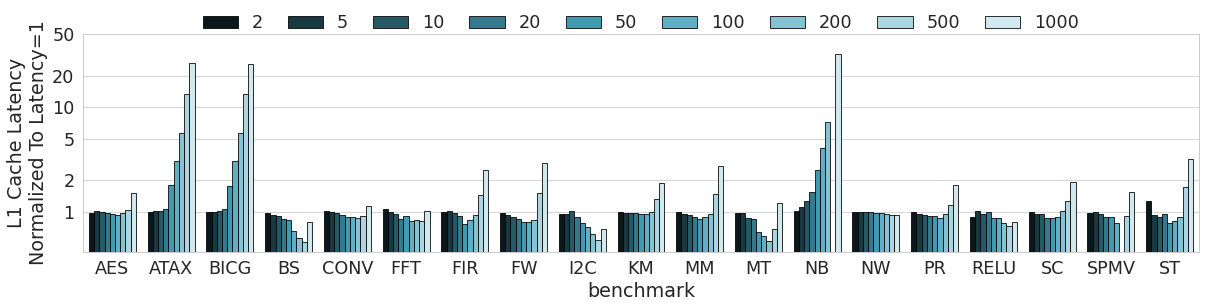

In [17]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(data = l1_latency_melt,
    x='benchmark', y='value', hue='-switch-latency',
    palette=sarchl.sequential_palette(9),
    ec='k',
    ax=ax)

ax.set_yscale('log')
ax.set_yticks([1, 2, 5, 10, 20, 50])
ax.set_yticklabels(['1', '2', '5', '10', '20', '50'])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, 
          frameon=False,
          fancybox=None, 
          columnspacing=1.4,
          facecolor=None, edgecolor=None, 
          bbox_to_anchor=(0.5, 1.05), loc=10, ncol=9)

ax.set_ylabel("L1 Cache Latency\nNormalized To Latency=1")

plt.savefig('l1_latency.pdf', bbox_inches='tight')
plt.show()
plt.close()

## L1 Cache Hit Rate

In [18]:
l1_cache_hit_data = raw[(raw['where'].str.contains('L1VCache')) & (raw['what']!='req_average_latency')]
l1_cache_hit_data

,benchmark,-switch-latency,where,what,value
2138,AES,1,GPU_0_0.SA_00.L1VCache_00,read-hit,55499.0
2139,AES,1,GPU_0_0.SA_00.L1VCache_00,read-miss,984.0
2140,AES,1,GPU_0_0.SA_00.L1VCache_00,read-mshr-hit,0.0
2141,AES,1,GPU_0_0.SA_00.L1VCache_00,write-hit,276.0
2142,AES,1,GPU_0_0.SA_00.L1VCache_00,write-miss,700.0
...,...,...,...,...,...
10053,ST,1000,GPU_4_4.SA_07.L1VCache_03,read-miss,267.0
10054,ST,1000,GPU_4_4.SA_07.L1VCache_03,read-mshr-hit,0.0
10055,ST,1000,GPU_4_4.SA_07.L1VCache_03,write-hit,0.0
10056,ST,1000,GPU_4_4.SA_07.L1VCache_03,write-miss,256.0


In [19]:
l1_cache_hit_data = l1_cache_hit_data.pivot(
    index=['benchmark', '-switch-latency', 'where'],
    columns='what',
    values='value',
).reset_index()
l1_cache_hit_data.columns = l1_cache_hit_data.columns.str.strip()

l1_cache_hit_data

what,benchmark,-switch-latency,where,read-hit,read-miss,read-mshr-hit,write-hit,write-miss,write-mshr-hit
0,AES,1,GPU_0_0.SA_00.L1VCache_00,55499.0,984.0,0.0,276.0,700.0,0.0
1,AES,1,GPU_0_0.SA_00.L1VCache_01,60958.0,1080.0,0.0,264.0,808.0,0.0
2,AES,1,GPU_0_0.SA_00.L1VCache_02,72790.0,1288.0,0.0,264.0,1016.0,0.0
3,AES,1,GPU_0_0.SA_00.L1VCache_03,36380.0,648.0,0.0,264.0,376.0,0.0
4,AES,1,GPU_0_0.SA_01.L1VCache_00,58223.0,1032.0,0.0,292.0,732.0,0.0
...,...,...,...,...,...,...,...,...,...
108356,ST,1000,GPU_4_4.SA_06.L1VCache_03,94.0,267.0,0.0,0.0,256.0,0.0
108357,ST,1000,GPU_4_4.SA_07.L1VCache_00,94.0,267.0,0.0,0.0,256.0,0.0
108358,ST,1000,GPU_4_4.SA_07.L1VCache_01,94.0,267.0,0.0,0.0,256.0,0.0
108359,ST,1000,GPU_4_4.SA_07.L1VCache_02,94.0,267.0,0.0,0.0,256.0,0.0


In [20]:
hit_count = l1_cache_hit_data['read-hit'] + l1_cache_hit_data['write-hit']
trans_count = hit_count + \
    l1_cache_hit_data['read-miss'] + l1_cache_hit_data['read-mshr-hit'] + \
    l1_cache_hit_data['write-miss'] + l1_cache_hit_data['write-mshr-hit']
hit_rate = hit_count/trans_count
l1_cache_hit_data['hit_rate'] = hit_rate
l1_cache_hit_data

what,benchmark,-switch-latency,where,read-hit,read-miss,read-mshr-hit,write-hit,write-miss,write-mshr-hit,hit_rate
0,AES,1,GPU_0_0.SA_00.L1VCache_00,55499.0,984.0,0.0,276.0,700.0,0.0,0.970692
1,AES,1,GPU_0_0.SA_00.L1VCache_01,60958.0,1080.0,0.0,264.0,808.0,0.0,0.970084
2,AES,1,GPU_0_0.SA_00.L1VCache_02,72790.0,1288.0,0.0,264.0,1016.0,0.0,0.969426
3,AES,1,GPU_0_0.SA_00.L1VCache_03,36380.0,648.0,0.0,264.0,376.0,0.0,0.972815
4,AES,1,GPU_0_0.SA_01.L1VCache_00,58223.0,1032.0,0.0,292.0,732.0,0.0,0.970736
...,...,...,...,...,...,...,...,...,...,...
108356,ST,1000,GPU_4_4.SA_06.L1VCache_03,94.0,267.0,0.0,0.0,256.0,0.0,0.152350
108357,ST,1000,GPU_4_4.SA_07.L1VCache_00,94.0,267.0,0.0,0.0,256.0,0.0,0.152350
108358,ST,1000,GPU_4_4.SA_07.L1VCache_01,94.0,267.0,0.0,0.0,256.0,0.0,0.152350
108359,ST,1000,GPU_4_4.SA_07.L1VCache_02,94.0,267.0,0.0,0.0,256.0,0.0,0.152350


In [21]:
l1_cache_hit_data = l1_cache_hit_data.groupby(['benchmark', '-switch-latency']).mean().reset_index()
l1_cache_hit_data


what,benchmark,-switch-latency,read-hit,read-miss,read-mshr-hit,write-hit,write-miss,write-mshr-hit,hit_rate
0,AES,1,60653.410156,1074.908854,0.0,266.230469,800.436198,0.0,0.970400
1,AES,2,60653.173177,1074.947917,0.0,267.414062,799.252604,0.0,0.970414
2,AES,5,60653.385417,1074.964844,0.0,266.424479,800.242188,0.0,0.970377
3,AES,10,60652.428385,1075.026042,0.0,267.557292,799.109375,0.0,0.970374
4,AES,20,60649.707031,1075.132812,0.0,268.119792,798.546875,0.0,0.970359
...,...,...,...,...,...,...,...,...,...
183,ST,50,444.416667,1966.093750,0.0,0.019531,1218.774740,0.0,0.111686
184,ST,100,113.449219,2084.273438,0.0,0.000000,946.251302,0.0,0.038412
185,ST,200,46.710938,1433.783854,0.0,0.000000,372.977865,0.0,0.029154
186,ST,500,42.213542,1414.496094,0.0,0.000000,281.816406,0.0,0.027794


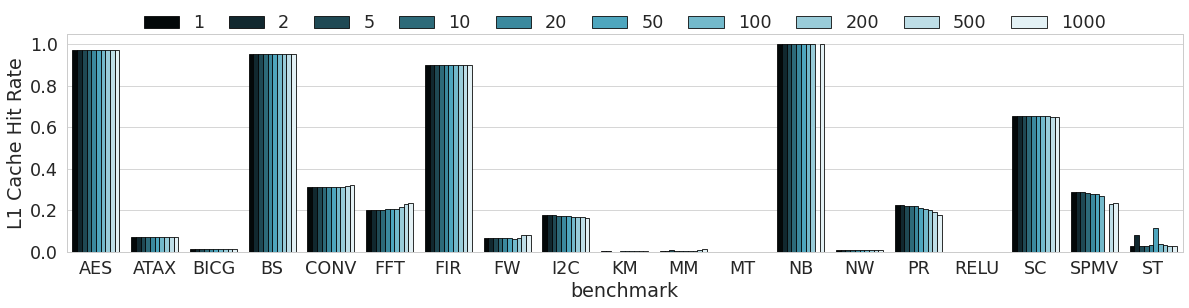

In [22]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(data = l1_cache_hit_data,
    x='benchmark', y='hit_rate', hue='-switch-latency',
    palette=sarchl.sequential_palette(10),
    ec='k',
    ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, 
          frameon=False,
          fancybox=None, 
          columnspacing=1.4,
          facecolor=None, edgecolor=None, 
          bbox_to_anchor=(0.5, 1.05), loc=10, ncol=10)

ax.set_ylabel("L1 Cache Hit Rate")

plt.savefig('l1_hit_rate.pdf', bbox_inches='tight')
plt.show()
plt.close()

## L2 Cache Hit Rate

In [59]:
l2_cache_hit_data = raw[(raw['where'].str.contains('L2_')) & (raw['what']!='req_average_latency')]
l2_cache_hit_data

,benchmark,-switch-latency,where,what,value
2426,AES,1,GPU_0_0.L2_0,read-hit,0.0
2427,AES,1,GPU_0_0.L2_0,read-miss,4272.0
2428,AES,1,GPU_0_0.L2_0,read-mshr-hit,0.0
2429,AES,1,GPU_0_0.L2_0,write-hit,4186.0
2430,AES,1,GPU_0_0.L2_0,write-miss,86.0
...,...,...,...,...,...
10197,ST,1000,GPU_4_4.L2_7,read-miss,3832.0
10198,ST,1000,GPU_4_4.L2_7,read-mshr-hit,0.0
10199,ST,1000,GPU_4_4.L2_7,write-hit,85.0
10200,ST,1000,GPU_4_4.L2_7,write-miss,1920.0


In [60]:
l2_cache_hit_data = l2_cache_hit_data.pivot(
    index=['benchmark', '-switch-latency', 'where'],
    columns='what',
    values='value',
).reset_index()
l2_cache_hit_data.columns = l2_cache_hit_data.columns.str.strip()

l2_cache_hit_data

what,benchmark,-switch-latency,where,read-hit,read-miss,read-mshr-hit,write-hit,write-miss,write-mshr-hit
0,AES,1,GPU_0_0.L2_0,0.0,4272.0,0.0,4186.0,86.0,0.0
1,AES,1,GPU_0_0.L2_1,0.0,4272.0,0.0,4186.0,86.0,0.0
2,AES,1,GPU_0_0.L2_2,0.0,4272.0,0.0,4186.0,86.0,0.0
3,AES,1,GPU_0_0.L2_3,0.0,4272.0,0.0,4187.0,85.0,0.0
4,AES,1,GPU_0_0.L2_4,0.0,4272.0,0.0,4188.0,84.0,0.0
...,...,...,...,...,...,...,...,...,...
33369,ST,1000,GPU_4_4.L2_3,1983.0,3860.0,0.0,100.0,1960.0,0.0
33370,ST,1000,GPU_4_4.L2_4,2225.0,3833.0,0.0,96.0,1944.0,0.0
33371,ST,1000,GPU_4_4.L2_5,1951.0,3874.0,0.0,75.0,1976.0,0.0
33372,ST,1000,GPU_4_4.L2_6,2251.0,3797.0,0.0,88.0,1921.0,0.0


In [61]:
# hit_count = l2_cache_hit_data['read-hit'] + l2_cache_hit_data['write-hit']
# trans_count = hit_count + \
#     l2_cache_hit_data['read-miss'] + l2_cache_hit_data['read-mshr-hit'] + \
#     l2_cache_hit_data['write-miss'] + l2_cache_hit_data['write-mshr-hit']
# hit_rate = hit_count/trans_count
# l2_cache_hit_data['hit_rate'] = hit_rate
# l2_cache_hit_data

hit_count = l2_cache_hit_data['read-hit']
trans_count = hit_count + \
    l2_cache_hit_data['read-miss']
hit_rate = hit_count/trans_count
l2_cache_hit_data['hit_rate'] = hit_rate
l2_cache_hit_data

what,benchmark,-switch-latency,where,read-hit,read-miss,read-mshr-hit,write-hit,write-miss,write-mshr-hit,hit_rate
0,AES,1,GPU_0_0.L2_0,0.0,4272.0,0.0,4186.0,86.0,0.0,0.000000
1,AES,1,GPU_0_0.L2_1,0.0,4272.0,0.0,4186.0,86.0,0.0,0.000000
2,AES,1,GPU_0_0.L2_2,0.0,4272.0,0.0,4186.0,86.0,0.0,0.000000
3,AES,1,GPU_0_0.L2_3,0.0,4272.0,0.0,4187.0,85.0,0.0,0.000000
4,AES,1,GPU_0_0.L2_4,0.0,4272.0,0.0,4188.0,84.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
33369,ST,1000,GPU_4_4.L2_3,1983.0,3860.0,0.0,100.0,1960.0,0.0,0.339380
33370,ST,1000,GPU_4_4.L2_4,2225.0,3833.0,0.0,96.0,1944.0,0.0,0.367283
33371,ST,1000,GPU_4_4.L2_5,1951.0,3874.0,0.0,75.0,1976.0,0.0,0.334936
33372,ST,1000,GPU_4_4.L2_6,2251.0,3797.0,0.0,88.0,1921.0,0.0,0.372189


In [62]:
l2_cache_hit_data = l2_cache_hit_data.groupby(['benchmark', '-switch-latency']).mean().reset_index()
l2_cache_hit_data

what,benchmark,-switch-latency,read-hit,read-miss,read-mshr-hit,write-hit,write-miss,write-mshr-hit,hit_rate
0,AES,1,2061.947917,4266.890625,0.0,4243.786458,22.880208,0.0,0.027676
1,AES,2,3478.005208,4266.890625,0.0,4239.208333,27.458333,0.0,0.030406
2,AES,5,2664.281250,4266.890625,0.0,4240.531250,26.135417,0.0,0.025750
3,AES,10,2252.645833,4266.890625,0.0,4238.677083,27.989583,0.0,0.027369
4,AES,20,2622.197917,4266.890625,0.0,4253.921875,12.744792,0.0,0.021439
...,...,...,...,...,...,...,...,...,...
183,ST,50,14085.359375,5055.203125,0.0,1320.557292,3549.057292,0.0,0.404576
184,ST,100,12586.942708,5762.848958,0.0,244.927083,3533.958333,0.0,0.349973
185,ST,200,5741.869792,3709.375000,0.0,43.651042,1442.526042,0.0,0.370993
186,ST,500,3202.208333,3706.614583,0.0,33.854167,1083.687500,0.0,0.360376


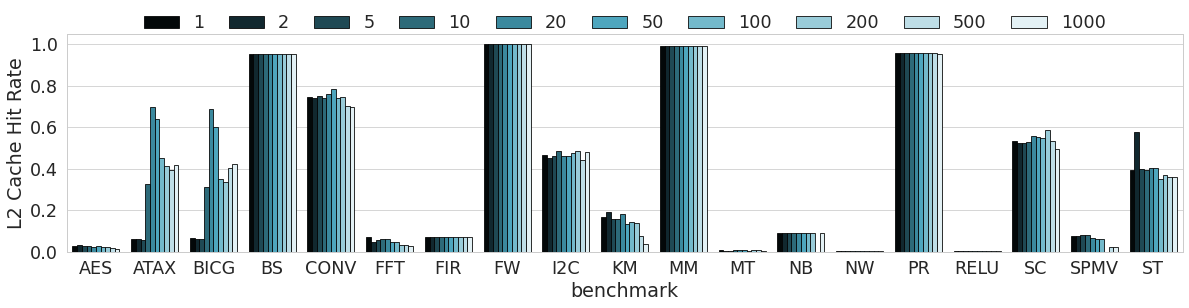

In [63]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(data = l2_cache_hit_data,
    x='benchmark', y='hit_rate', hue='-switch-latency',
    palette=sarchl.sequential_palette(10),
    ec='k',
    ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, 
          frameon=False,
          fancybox=None, 
          columnspacing=1.4,
          facecolor=None, edgecolor=None, 
          bbox_to_anchor=(0.5, 1.05), loc=10, ncol=10)

ax.set_ylabel("L2 Cache Hit Rate")

plt.savefig('l2_hit_rate.pdf', bbox_inches='tight')
plt.show()
plt.close()

## L2 Latency

In [32]:
l2_data_avg_latency_data = raw[(raw['where'].str.contains('L1VCache')) & (raw['what']=='req_average_latency')]
l2_data_avg_latency_data

,benchmark,-switch-latency,where,what,value
810,AES,1,GPU_0_0.SA_00.L1VCache_00,req_average_latency,2.282800e-07
811,AES,1,GPU_0_0.SA_00.L1VCache_01,req_average_latency,2.269370e-07
812,AES,1,GPU_0_0.SA_00.L1VCache_02,req_average_latency,1.958500e-07
813,AES,1,GPU_0_0.SA_00.L1VCache_03,req_average_latency,2.869880e-07
814,AES,1,GPU_0_0.SA_01.L1VCache_00,req_average_latency,2.355110e-07
...,...,...,...,...,...
2125,ST,1000,GPU_4_4.SA_06.L1VCache_03,req_average_latency,7.154611e-06
2126,ST,1000,GPU_4_4.SA_07.L1VCache_00,req_average_latency,6.802037e-06
2127,ST,1000,GPU_4_4.SA_07.L1VCache_01,req_average_latency,7.083271e-06
2128,ST,1000,GPU_4_4.SA_07.L1VCache_02,req_average_latency,6.804853e-06


In [33]:
l2_benchmark_avg_latency_data = l2_data_avg_latency_data \
    .groupby(['benchmark', '-switch-latency']).mean()
l2_benchmark_avg_latency_data = l2_benchmark_avg_latency_data.reset_index()
l2_benchmark_avg_latency_data

,benchmark,-switch-latency,value
0,AES,1,1.974551e-07
1,AES,2,1.934476e-07
2,AES,5,2.020659e-07
3,AES,10,1.983670e-07
4,AES,20,1.927280e-07
...,...,...,...
183,ST,50,1.572182e-06
184,ST,100,1.627216e-06
185,ST,200,1.782692e-06
186,ST,500,3.496741e-06


In [40]:
l2_latency_pivot = l2_benchmark_avg_latency_data.pivot(
    index='benchmark',
    columns='-switch-latency',
    values='value',
).reset_index()
l2_latency_pivot.columns = ['benchmark', '1', '2', '5', '10', '20', '50', '100', '200', '500', '1000']
l2_latency_pivot

,benchmark,1,2,5,10,20,50,100,200,500,1000
0,AES,1.974551e-07,1.934476e-07,2.020659e-07,1.983670e-07,1.927280e-07,1.903043e-07,1.831137e-07,1.927336e-07,2.069602e-07,2.973931e-07
1,ATAX,1.038760e-06,1.040449e-06,1.046484e-06,1.050921e-06,1.106248e-06,1.860543e-06,3.206999e-06,5.890007e-06,1.394376e-05,2.735437e-05
2,BICG,1.038795e-06,1.040456e-06,1.045951e-06,1.050470e-06,1.105665e-06,1.851581e-06,3.194694e-06,5.852627e-06,1.382344e-05,2.710721e-05
3,BS,4.708162e-06,4.618670e-06,4.395773e-06,4.304266e-06,4.051743e-06,3.973116e-06,3.113659e-06,2.668862e-06,2.417457e-06,3.778573e-06
4,CONV,4.225087e-06,4.265238e-06,4.164518e-06,4.073119e-06,3.955137e-06,3.741512e-06,3.754458e-06,3.719348e-06,3.875599e-06,4.779989e-06
5,FFT,6.637192e-06,7.125288e-06,6.655712e-06,6.335523e-06,5.690927e-06,6.068655e-06,5.391138e-06,5.488622e-06,5.449945e-06,6.740931e-06
6,FIR,3.022111e-07,2.993056e-07,3.066346e-07,2.914139e-07,2.737791e-07,2.287232e-07,2.516169e-07,2.822049e-07,4.405141e-07,7.611131e-07
7,FW,4.751706e-06,4.678437e-06,4.444946e-06,4.246929e-06,4.075638e-06,3.828773e-06,3.798882e-06,4.010995e-06,7.117861e-06,1.390140e-05
8,I2C,8.455944e-06,8.120942e-06,8.056455e-06,8.574615e-06,7.596082e-06,6.661952e-06,6.030420e-06,5.217163e-06,4.583817e-06,5.738836e-06
9,KM,3.542755e-06,3.508824e-06,3.477684e-06,3.455150e-06,3.456498e-06,3.386081e-06,3.352805e-06,3.555908e-06,4.681197e-06,6.682431e-06


In [42]:
l2_latency_normalize = l2_latency_pivot.copy()
l2_latency_normalize['2'] = \
    l2_latency_normalize['2'] / l2_latency_normalize['1']
l2_latency_normalize['5'] = \
    l2_latency_normalize['5'] / l2_latency_normalize['1']
l2_latency_normalize['10'] = \
    l2_latency_normalize['10'] / l2_latency_normalize['1']
l2_latency_normalize['20'] = \
    l2_latency_normalize['20'] / l2_latency_normalize['1']
l2_latency_normalize['50'] = \
    l2_latency_normalize['50'] / l2_latency_normalize['1']
l2_latency_normalize['100'] = \
    l2_latency_normalize['100'] / l2_latency_normalize['1']
l2_latency_normalize['200'] = \
    l2_latency_normalize['200'] / l2_latency_normalize['1']
l2_latency_normalize['500'] = \
    l2_latency_normalize['500'] / l2_latency_normalize['1']
l2_latency_normalize['1000'] = \
    l2_latency_normalize['1000'] / l2_latency_normalize['1']
l2_latency_normalize['1'] = 1
l2_latency_normalize


,benchmark,1,2,5,10,20,50,100,200,500,1000
0,AES,1,0.979704,1.023351,1.004618,0.976060,0.963785,0.927369,0.976088,1.048138,1.506131
1,ATAX,1,1.001625,1.007436,1.011707,1.064970,1.791119,3.087333,5.670229,13.423467,26.333678
2,BICG,1,1.001599,1.006888,1.011239,1.064372,1.782431,3.075383,5.634051,13.307184,26.094853
3,BS,1,0.980992,0.933650,0.914214,0.860579,0.843879,0.661332,0.566859,0.513461,0.802558
4,CONV,1,1.009503,0.985664,0.964032,0.936108,0.885547,0.888611,0.880301,0.917283,1.131335
5,FFT,1,1.073540,1.002790,0.954549,0.857430,0.914341,0.812262,0.826949,0.821122,1.015630
6,FIR,1,0.990386,1.014637,0.964273,0.905920,0.756833,0.832587,0.933801,1.457637,2.518482
7,FW,1,0.984580,0.935442,0.893769,0.857721,0.805768,0.799477,0.844117,1.497959,2.925559
8,I2C,1,0.960383,0.952756,1.014034,0.898313,0.787842,0.713157,0.616982,0.542082,0.678675
9,KM,1,0.990423,0.981633,0.975272,0.975653,0.955776,0.946384,1.003713,1.321344,1.886224


In [43]:
l2_latency_melt = l2_latency_normalize.melt(
    id_vars=['benchmark'],
    value_vars=['2', '5', '10', '20', '50', '100', '200', '500', '1000'],
    var_name='-switch-latency',
    value_name='value',
)
l2_latency_melt

,benchmark,-switch-latency,value
0,AES,2,0.979704
1,ATAX,2,1.001625
2,BICG,2,1.001599
3,BS,2,0.980992
4,CONV,2,1.009503
...,...,...,...
166,PR,1000,1.821079
167,RELU,1000,0.793850
168,SC,1000,1.924439
169,SPMV,1000,1.559980


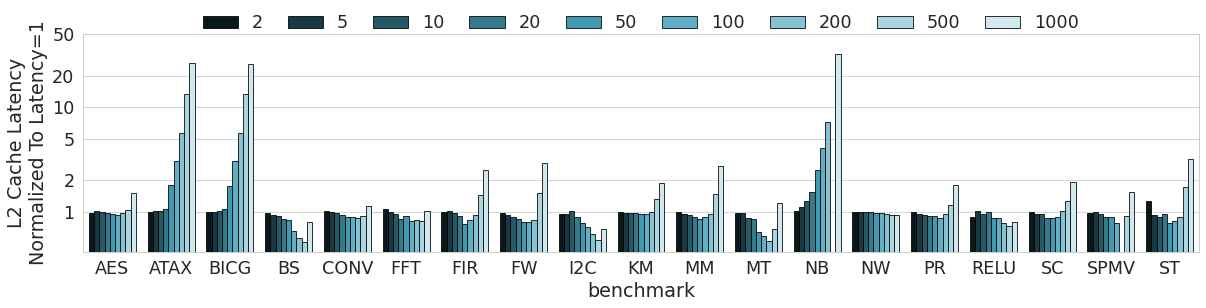

In [45]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(data = l2_latency_melt,
    x='benchmark', y='value', hue='-switch-latency',
    palette=sarchl.sequential_palette(9),
    ec='k',
    ax=ax)

ax.set_yscale('log')
ax.set_yticks([1, 2, 5, 10, 20, 50])
ax.set_yticklabels(['1', '2', '5', '10', '20', '50'])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, 
          frameon=False,
          fancybox=None, 
          columnspacing=1.4,
          facecolor=None, edgecolor=None, 
          bbox_to_anchor=(0.5, 1.05), loc=10, ncol=9)

ax.set_ylabel("L2 Cache Latency\nNormalized To Latency=1")

plt.savefig('l2_latency.pdf', bbox_inches='tight')
plt.show()
plt.close()